In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from scipy.integrate import solve_ivp, solve_bvp
from scipy.optimize import minimize, Bounds, root
from matplotlib import gridspec
import winsound
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

c  = 2.99792458e10;
h  = 6.6260755e-27;
G  = 6.67259e-8;
mp = 1.6726231e-24;
me = 9.1093897e-28;
qe = 4.8032068e-10;
mn = 1.6749286e-24;
am = 1.66053886e-24;
a0 = 5.29177e-9;
k  = 1.380658e-16;
sb = 5.67051e-5;
a  = 7.5646e-15;
eV = 1.6021772e-12;
Rg = 8.314e7;
au = 1.496e13;
pc = 206265#*au;

M_sun = 1.989e33;

Ms = M_sun * 1.
Rs = 6.96e10;
Ls = 3.826e33;
Re = 6.378e8;
Me = 5.9742e27;
Mj = 317.83#*Me;
Rj = 11.209#*Re;
yr = 365*24*3600;
st = 6.65e-25;



In [2]:
font={'size':16, 'family':'serif'}
plt.rc('font',**font)
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['xtick.labelsize']='large'
plt.rcParams['axes.labelsize']=24

plt.rcParams['figure.figsize']=(12,9)

plt.rcParams['xtick.minor.visible']='True'
plt.rcParams['ytick.minor.visible']='True'
plt.rcParams['figure.dpi']=60

plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True

plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

plt.rcParams['xtick.major.top']=True
plt.rcParams['xtick.minor.top']=True
plt.rcParams['ytick.major.right']=True
plt.rcParams['ytick.minor.right']=True

plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size']=6
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.minor.size']=6

plt.rcParams['xtick.major.width']=1.75
plt.rcParams['xtick.minor.width']=1.2
plt.rcParams['ytick.major.width']=1.75
plt.rcParams['ytick.minor.width']=1.2

plt.rcParams['savefig.bbox']='tight'
plt.rcParams['savefig.format']='pdf'
plt.rcParams['savefig.dpi']=400



In [3]:
def R_opacity(rho, T):
    
    # generates the R parameter as a function of rho and T
    
    return rho  / np.power(T / 1.0e6, 3.)


def create_opacity_interpolation(fn='table73.txt'):

#The purpose of this function is to create an interpolation function of the OPAL opacity table.
#I would like it to take a given value of R and T, and to return what it thinks the opacity at that value should be.
#I am going to use the X = 0.70, Y = 0.28 OPAL table here.

    df = np.genfromtxt(fn,skip_header=4)

#Obtain T, R, and kappa from the table
    
    logT = df[1:,0]
    T = np.power(10., logT)
    logR = df[0, 1:]
    R = np.power(10.,logR)
    log_opacities = df[1:,1:]
    opacities = np.power(10.,log_opacities)
    
#Create mesh of (R, T) tuples for interpolation
    
    xlogR, ylogT = np.meshgrid(logR, logT)

#Unravel the tuples/opacity grid so they are in a 1D array

    xlogR_flat = xlogR.ravel()
    ylogT_flat = ylogT.ravel()
    log_opacities_flat = log_opacities.ravel()
    
#Remove NaN from the opacities list, so the interpolator doesn't complain

    log_opacities_nan = np.isnan(log_opacities_flat)
    
    xlogR_nonan = xlogR_flat[~log_opacities_nan]
    ylogT_nonan = ylogT_flat[~log_opacities_nan]
    log_opacities_nonan = log_opacities_flat[~log_opacities_nan]

#Standard 2D interpolator from SciPy
    
    #interp = LinearNDInterpolator(list(zip(xR_nonan, yT_nonan)), opacities_nonan)
    interp = LinearNDInterpolator(list(zip(xlogR_nonan, ylogT_nonan)), log_opacities_nonan)

#Here I change the function to take in linear values of R and T, and to return linear opacities
#Since the differential equations etc. occur in linear space, this should lead to simpler code eventually.
    
    def non_log_interp(R, T):
        return np.power(10., interp(np.log10(R),np.log10(T)))

    return non_log_interp

0.0


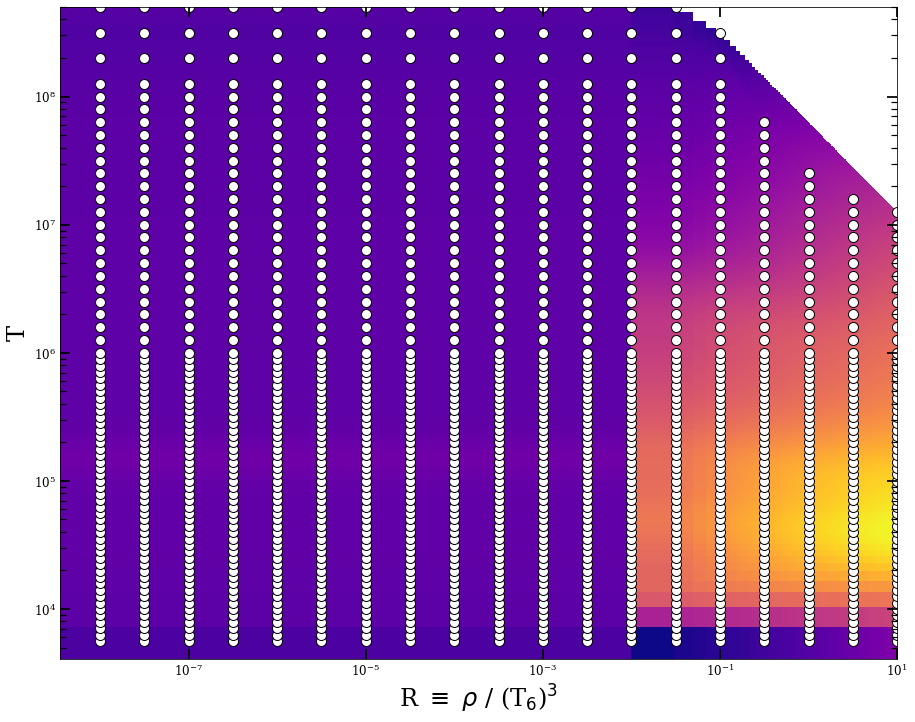

In [85]:
def generate_opacity_plot():
    
    func = create_opacity_interpolation()
    
#Now I want to show the range of interpolation available, with the same data as before.
    
    df = np.genfromtxt('table73.txt',skip_header=4)

#Same deal, R, T, kappa
    
    logT = df[1:,0]
    T = np.power(10., logT)
    logR = df[0, 1:]
    R = np.power(10.,logR)
    xR, yT = np.meshgrid(R, T)
    log_opacities = df[1:,1:]
    opacities = np.power(10.,log_opacities)

    xR_flat = xR.ravel()
    yT_flat = yT.ravel()
    opacities_flat = opacities.ravel()
    
    opacities_nan = np.isnan(opacities_flat)

    xR_nonan = xR_flat[~opacities_nan]
    yT_nonan = yT_flat[~opacities_nan]
    opacities_nonan = opacities_flat[~opacities_nan]
    
    
    fig = plt.figure(figsize=(15,12))
    gs = gridspec.GridSpec(1, 1)#, width_ratios=[3, 2]) 
    ax = fig.add_subplot(gs[0,0])
    ax.set_xlabel('R $\\equiv$ $\\rho$ / (T$_6$)$^3$', fontsize=24)
    ax.set_ylabel('T', fontsize=24)
    
    xs = np.linspace(np.min(xR_nonan), np.max(xR_nonan), num=500)
    ys = np.linspace(np.min(yT_nonan), np.max(yT_nonan), num=160000)
    xg, yg = np.meshgrid(xs, ys)
    
#This time, I'm going to input linear values of R and T to hopefully get linear values of kappa
#The opacities also vary across several orders of magnitude, so I'm taking the logarithm of them
#If this works, there should be a clear color gradient

    zg = func(xg, yg)
    
    ax.pcolormesh(xg, yg, np.log10(zg), shading='auto',cmap='plasma', rasterized=True)
    
#I also want to plot the interpolation points.
    
    ax.scatter(xR_nonan, yT_nonan, color='white', edgecolor='black', linewidth=1, s = 100., rasterized=True)
    #ax.set_xlim(-0.1, 10.5)
    #ax.set_ylim(-3e7, 5.2e8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    
#Also, to check that the interpolation recovers the correct values for the interpolation points, even in linear space:
#This should be 0 if it is successful.

    print(np.max(np.abs(opacities_nonan - func(xR_nonan, yT_nonan))))
    
    fig.savefig('Plots\\opacity_interpolation.pdf', dpi=400, bbox_inches='tight')
    
generate_opacity_plot()

In [4]:
def psi_T(T):
    
#This is the correction factor in the pp-chain energy generation rate, approximated for Y = 0.28.
    
    T7 = T / 1e7
    return 0.5 / (1 + np.exp(-3.5 * (T7 - 1.75))) + 1.


def energy_epsilon(rho, T, X, Z, verbose=False):
    
#The purpose of this function is to return the energy generation rate for a given density, temperature, and composition
#It uses the equations provided in Kippenhahn and Weigert, assuming weak screening.

#First, the energy generation rate approximation in the book blows up at small temperatures. So, I will set the
#Energy generation rate to be zero when the temperature is low (it's many orders of magnitude smaller than the rate
#at Solar core temperatures, so I assume that it is negligible.)
#This is related to the weak screening approximation from the book, which is an exponential that blows up for small T.

    #if type(T) == float or type(T) == int:
        #if T < 7e4:
            #return 0.
        

#The equation uses T9, or temperature divided by 1 billion Kelvin.

    T9 = T / 1e9

#This is from the Hansen book, which states that the fraction of CNO is 74% of the total metal fraction

    X_CNO = 0.74 * Z

#There is also a correction factor in Kippenhahn and Weigert related to the different PP-I, PP-II, and PP-III chains
#which have different efficiencies at different temperatures. It doesn't seem like there is an exact formula for this
#anywhere in the book or the paper it references, so I approximated it as a logistic curve.

    psi = psi_T(T)

#The shielding factor is an approximation for weak screening, directly from the book. It is usually close to 1 at 
#adequately high temperatures. 

    f_11 = np.exp(5.92e-3 * np.sqrt(rho / np.power(T /1e7, 3.)))

    if type(T) == float or (type(T) == int or type(T) == np.float64):

        if f_11 > 10. or np.isinf(f_11) ==  True:
            return 0.
    #print(T)
    #print(rho)
    #print(f_11)
#This is another factor in the equation

    g_11 = 1. + 3.82 * T9 + 1.51 * np.square(T9) + 0.144 * np.power(T9, 3.) - 0.0114 * np.power(T9, 4.)

#Okay, this is the entire equation.

    epsilon_pp = 2.57e4 * psi * f_11 * g_11 * rho * np.square(X) * np.power(T9, -2./3.) * np.exp(-3.381 / np.power(T9, 1./3.))

#Now for the CNO Cycle. This one's approximation is much more straightforward than the one for the pp-chain.
#It starts out with a polynomial temperature factor

    g_14_1 = 1. - 2. * T9 + 3.41 * np.square(T9) -2.43 * np.power(T9, 3.)

#And this is it.

    epsilon_CNO = 8.24e25 * g_14_1 * X_CNO * X * rho * np.power(T9, -2./3.) * np.exp(-15.231 * np.power(T9, -1./3.) -np.square(T9 / 0.8))

#Now all we have to do is add them together.

    epsilon = epsilon_pp + epsilon_CNO

#Normally, I won't want to return all three, since I'm interested in them combined, but for plotting purposes I will
#return all 3 of them, so as to reproduce Figure 18.8 in Kippenhahn and Weigert.

    if verbose == True:
        return epsilon, epsilon_pp, epsilon_CNO
    else:
        return epsilon

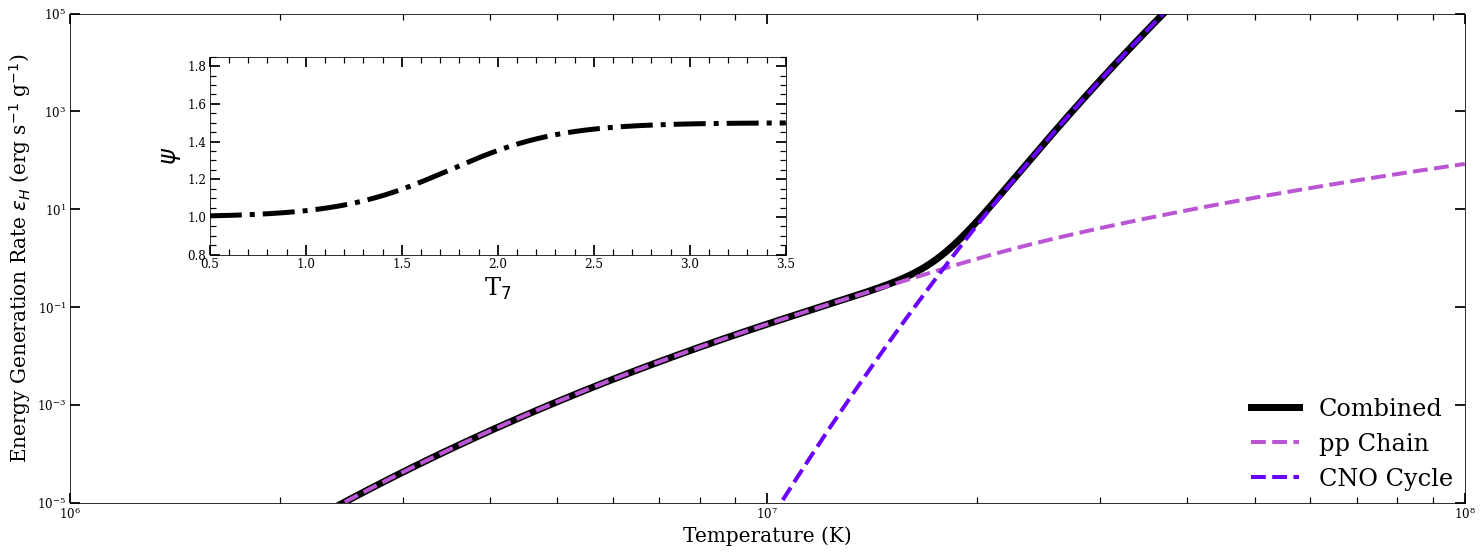

In [5]:
#This plot will re-create part of Figure 18.7 in Kippenhahn and Weigert.

def make_psi_plot(ax):

    Ts = np.linspace(.5e7,3.5e7, num=500)

    ax.plot(Ts/1e7, psi_T(Ts), color='k', lw=5, ls='-.')
    ax.set_ylim(0.8,1.85)
    ax.set_xlim(0.5, 3.5)
    ax.set_xlabel('T$_7$', fontsize=24)
    ax.set_ylabel(r'$\psi$', fontsize=24)
    plt.show()
    
#I want to double-check and make sure that my equation for the energy generation rate is accurate, so I'm going to try to
#Re-create Figure 18.8 from K & W.
    
def make_epsilon_plot():
    
    
#I call the epsilon function, and get the pp chain/CNO cycle rates in addition to the total rate
    
    Ts = np.logspace(6.0, 8., num=1000)
    eps, eps_pp, eps_cno = energy_epsilon(1., Ts, 0.7, 0.02, verbose=True)
    
    fig, ax = plt.subplots(1,1,figsize=(25,9))

    ax.plot(Ts, eps, color='k', lw=7, ls='-', label='Combined')
    ax.plot(Ts, eps_pp, color='#BA55D3', lw=4, ls='--', label='pp Chain')
    ax.plot(Ts, eps_cno, color='#6A00FF', lw=4, ls='--', label='CNO Cycle')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.legend()

#I also set the x and y ranges to span a similar amount as the original figure.
    
    ax.set_xlim(10**6., 10**8.)
    ax.set_ylim(1e-5, 1e5)
    
    ax.set_xlabel('Temperature (K)', fontsize=20)
    ax.set_ylabel(r'Energy Generation Rate $\epsilon_H$ (erg s$^{-1}$ g$^{-1}$)', fontsize=20)
    
#I'll also include the portion of Figure 18.7 in the plot, since there's a lot of white space currently.
    
    ax_ins = inset_axes(ax,8.0, 2.75, loc=3, bbox_to_anchor=(0.2, 0.5), bbox_transform=ax.figure.transFigure)
    ax.legend(loc='lower right', frameon=False, fancybox=False,borderpad=0.0, fontsize=24)
    make_psi_plot(ax_ins)
    
    plt.show()
    fig.savefig('Plots\\epsilon.pdf', dpi=400, bbox_inches='tight')
    
def main():

    make_epsilon_plot()
    
main()

In [6]:
def density(P, T, X):

    radiation_pressure = a * np.power(T, 4.) / 3.
    
    mu = 4. / (3. + 5. * X)
    ideal_gas_pressure = P - radiation_pressure
    rho = ideal_gas_pressure * mu / (T * Rg)
    
    return rho


def del_radiative(Mr, P, kappa, T, Lr):
    
    grad = (3. / (16 * np.pi * a * c * G)) * (P * kappa / np.power(T, 4.)) * (Lr/Mr)

    if np.isnan(grad) == True:

        return 2.
    else:
        return grad

def del_adiabatic(P, T):
    
    radiation_pressure = a * np.power(T, 4.) / 3.
    ideal_gas_pressure = P - radiation_pressure
    
    beta = ideal_gas_pressure / P
    
    del_ad = 2. * (4. - 3. * beta) / (32. - 24. * beta - 3. * np.square(beta))
    
    return del_ad


def choose_gradient(Mr, P, kappa, T, Lr, verbose=False):
    
    rad = del_radiative(Mr, P, kappa, T, Lr)
    ad  = del_adiabatic(P, T)
    
    #print(rad)
    #print(ad)
    #print()
    
    if np.abs(rad) <= np.abs(ad):
        if verbose == True:
            return rad, 'Radiative'
        else:
            return rad
    
    else:
        if verbose == True:
            return ad, 'Convective'
        else:
            return ad

In [7]:
opacity_function = create_opacity_interpolation()

def dydx_stellarstructure(m, y):
    l, P, r, T = y
    X = 0.7; Z = 0.02;
    
    
    rho = density(P, T, X)
    R = R_opacity(rho, T)
    
    kappa = opacity_function(R, T)
    
#A failsafe if kappa is outside the normal bounds (around what the largest value in the opacity table is)
    
    if np.isnan(kappa) == True:
        
        kappa = 2.0e5

    dldm = energy_epsilon(rho, T, X, Z)
    dPdm = -G * m / (4. * np.pi * np.power(r, 4.))
    drdm = np.power(4. * np.pi * np.square(r) * rho, -1.)
    dTdm = -G * m * T * choose_gradient(m, P, kappa, T, l) / (4. * np.pi * np.power(r, 4.) * P)
    
    return dldm, dPdm, drdm, dTdm

In [8]:
def load1(Pc, Tc, m_cutoff = 1e-10 * Ms):

    X = 0.7; Z = 0.02;
    
    rhoc = density(Pc, Tc, X)
    Rc = R_opacity(rhoc, Tc)
    kappac = opacity_function(Rc, Tc)

    epsilonc = energy_epsilon(rhoc, Tc, X, Z)

    l_init_inner = epsilonc * m_cutoff
    
    P_init_inner = Pc - (3. * G / (8. * np.pi)) * np.power(4. * np.pi * rhoc / 3., 4./3.) * np.power(m_cutoff, 2./3.)
    
    r_init_inner = np.power(3. * m_cutoff / (4. * np.pi * rhoc), 1./3.)
    
    T_init_inner = np.power(np.power(Tc, 4.) - (1./(2. * a  *c)) * np.power(0.75/np.pi, 2./3.) * kappac * epsilonc * np.power(rhoc, 4./3.) * np.power(m_cutoff, 2./3.) ,0.25)

    return l_init_inner, P_init_inner, r_init_inner, T_init_inner
    
def load2(Lstar, Rstar):

    T_init_outer = np.power(Lstar / (4. * np.pi * np.square(Rstar) * sb), 0.25)

#So I'm not sure where I could find a good number for the density of the sun at the photosphere,
#but I did find that it was 2 * 10^-7 g cm^-3 from reddit, so I'll go with that for now.

    R = R_opacity(2e-7, T_init_outer)

    kappa = opacity_function(R, T_init_outer)
    
#Sometimes the minimizer may try a set of parameters that, while reasonable to it, are in fact outside of the 
#range of the opacity interpolator when calculating the pressure at the photosphere.
#This often occurs when the temperature is very low (i.e. large radius or low luminosity, or both)
#So, to circumvent this, I will just set it equal to .25 cm^2 g^-1 when it can't obtain it from the interpolator.
#The main problem here is that I do not know where I would be able to obtain a reasonable surface density for stars
#like that. I imagine that for a larger radius it would be smaller, but I don't know by how much
#or how I would calculate it.

    if np.isnan(kappa) == True:
        kappa = 0.25
    

    P_init_outer = (2./3.) * G * (Ms / np.square(Rstar)) / kappa
    
    l_init_outer = Lstar
    
    r_init_outer = Rstar
    
    return l_init_outer, P_init_outer, r_init_outer, T_init_outer



In [12]:
def fshoot(Pc, Tc, Lstar, Rstar):
    cutoff_fraction = .5
    center_limit = 1e-12
    
    l_init_inner, P_init_inner, r_init_inner, T_init_inner = load1(Pc, Tc)
    l_init_outer, P_init_outer, r_init_outer, T_init_outer = load2(Lstar, Rstar)

    inner_range = np.linspace(center_limit * Ms,  Ms * cutoff_fraction, num=100_000)

    outer_range_2 = (1. -1. * np.power(10., np.linspace(-8,-1, num=10001))) * Ms
    outer_range_1 = np.linspace((1 - 1e-1) * Ms, Ms * cutoff_fine, num=97_000)
    outer_range = np.concatenate((outer_range_2[:-2], outer_range_1))

    inner_result = solve_ivp(dydx_stellarstructure,[center_limit * Ms, Ms  * cutoff_fraction], [l_init_inner, P_init_inner, r_init_inner, T_init_inner], method= 'BDF' ,t_eval = inner_range)
    outer_result = solve_ivp(dydx_stellarstructure,[Ms, Ms * cutoff_fraction], [l_init_outer, P_init_outer, r_init_outer, T_init_outer], method= 'BDF' ,t_eval = outer_range)
    
    return inner_result, outer_result
    
    
def fshoot_fine(Pc, Tc, Lstar, Rstar):
    cutoff_fine = .5
    center_fine = 1e-20
    
    l_init_inner, P_init_inner, r_init_inner, T_init_inner = load1(Pc, Tc)
    l_init_outer, P_init_outer, r_init_outer, T_init_outer = load2(Lstar, Rstar)
    
    inner_range = np.linspace(center_fine * Ms,  Ms * cutoff_fine, num=100_000)

    outer_range_2 = (1. -1. * np.power(10., np.linspace(-8,-1, num=10001))) * Ms
    outer_range_1 = np.linspace((1 - 1e-1) * Ms, Ms * cutoff_fine, num=97_000)
    outer_range = np.concatenate((outer_range_2[:-2], outer_range_1))
    
    inner_result = solve_ivp(dydx_stellarstructure,[center_fine * Ms, Ms  * cutoff_fine], [l_init_inner, P_init_inner, r_init_inner, T_init_inner], method= 'BDF' ,t_eval = inner_range)
    outer_result = solve_ivp(dydx_stellarstructure,[Ms, Ms * cutoff_fine], [l_init_outer, P_init_outer, r_init_outer, T_init_outer], method= 'BDF' ,t_eval = outer_range)
    
    return inner_result, outer_result
    

In [10]:
def fSCO_root(inputs):
    
#Here I want to take the last point on each pressure, temperature, luminosity, and radius array, and find the
#difference between each one (as they should represent the degree of disagreement between the inner and outer)
#integrations.
#This is then what I will try to root find as the scoring function.
    
    #lambda_P, lambda_T, lambda_L, lambda_R = inputs
    
    Pc, Tc, Lstar, Rstar = inputs#define_inputs([lambda_P, lambda_T, lambda_L, lambda_R])
    
    #print(Pc/2.477e17, Tc/1.571e7, Lstar/3.846e33, Rstar/6.957e10)
    #d_in, d_out = fshoot(2.477e17, 1.571e7, 3.846e33, 6.957e10)
    #print(d_in, d_out)
    inner_result, outer_result = fshoot(Pc, Tc, Lstar, Rstar)
    #print(inner_result);
    #print(outer_result)
    #print('a')
    
    inner_result_y = inner_result.y
    #print('b')
    inner_result_l = inner_result.y[0]
    inner_result_P = inner_result.y[1]
    inner_result_r = inner_result.y[2]
    inner_result_T = inner_result.y[3]

    outer_result_y = outer_result.y
    #print('c')
    outer_result_l = outer_result.y[0]
    outer_result_P = outer_result.y[1]
    outer_result_r = outer_result.y[2]
    outer_result_T = outer_result.y[3]
    #print('d')
    #print(outer_result_l, outer_result_P, outer_result_r, outer_result_T)
    l_diff = inner_result_l[-1] - outer_result_l[-1]
    P_diff = inner_result_P[-1] - outer_result_P[-1]
    r_diff = inner_result_r[-1] - outer_result_r[-1]
    T_diff = inner_result_T[-1] - outer_result_T[-1]
    #print('e')

    return [l_diff/Lstar,P_diff/Pc,r_diff/Rstar,T_diff/Tc]


4.9998e+33 37307.64860823582 97398000000.0 5215.009961843416


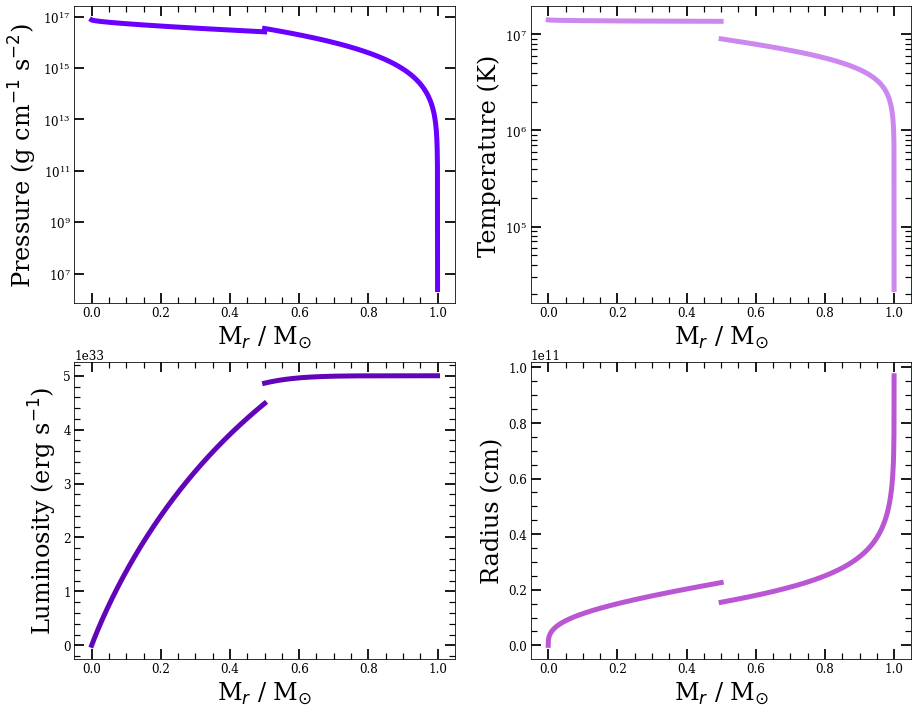

In [11]:
def plot_attempt(inner_result, outer_result):
    
#This code will create a plot of a shoot's results, given the output from both the inner and outer integrations.
    
    fig, ((ax_P, ax_T),(ax_L, ax_R)) = plt.subplots(2,2, figsize=(15,12))
    
    ax_P.set_ylabel('Pressure (g cm$^{-1}$ s$^{-2}$)') ; ax_P.set_xlabel(r'M$_r$ / M$_{\odot}$')
    ax_T.set_ylabel('Temperature (K)') ; ax_T.set_xlabel(r'M$_r$ / M$_{\odot}$')
    ax_L.set_ylabel('Luminosity (erg s$^{-1}$)') ; ax_L.set_xlabel(r'M$_r$ / M$_{\odot}$')
    ax_R.set_ylabel('Radius (cm)') ; ax_R.set_xlabel(r'M$_r$ / M$_{\odot}$')
    
#I want to set the pressure and temeperature scales to logarithmic, as these values never truly go to zero.
#Meanwhile, luminosity and radius "start" at ~zero, so it makes more sense for them to be linear.
    
    ax_P.set_yscale('log')
    ax_T.set_yscale('log')
    #ax_R.set_xscale('log')
    #ax_L.set_yscale('log')
    
    inner_result_m = inner_result.t
    inner_result_y = inner_result.y
    
    inner_result_l = inner_result.y[0]
    inner_result_P = inner_result.y[1]
    inner_result_r = inner_result.y[2]
    inner_result_T = inner_result.y[3]
    
    outer_result_m = outer_result.t
    outer_result_y = outer_result.y
    
    outer_result_l = outer_result.y[0]
    outer_result_P = outer_result.y[1]
    outer_result_r = outer_result.y[2]
    outer_result_T = outer_result.y[3]
    
    plot_line_width = 5
    
    ax_P.plot(inner_result_m/outer_result_m[0], inner_result_P, color='#6A00FF', lw=plot_line_width)
    ax_P.plot(outer_result_m/outer_result_m[0], outer_result_P, color='#6A00FF', lw=plot_line_width)
    
    ax_T.plot(inner_result_m/outer_result_m[0], inner_result_T, color='#CD88EF', lw=plot_line_width)
    ax_T.plot(outer_result_m/outer_result_m[0], outer_result_T, color='#CD88EF', lw=plot_line_width)
    
    ax_L.plot(inner_result_m/outer_result_m[0], inner_result_l, color='#6205B8', lw=plot_line_width)
    ax_L.plot(outer_result_m/outer_result_m[0], outer_result_l, color='#6205B8', lw=plot_line_width)
    
    ax_R.plot(inner_result_m/outer_result_m[0], inner_result_r, color='#BA55D3', lw=plot_line_width)
    ax_R.plot(outer_result_m/outer_result_m[0], outer_result_r, color='#BA55D3', lw=plot_line_width)

    return fig, ax_P, ax_T, ax_L, ax_R
    



#pressure, temperature, luminosity, radius

test_array = [0.3,0.9, 1.3, 1.4]

d_in, d_out = fshoot(2.477e17*test_array[0], 1.571e7*test_array[1], 3.846e33*test_array[2], 6.957e10*test_array[3])
fig, ax_P, ax_T, ax_L, ax_R = plot_attempt(d_in, d_out)


    fjac: array([[-0.47489642, -0.02673135, -0.04808446, -0.87832039],
       [-0.6595809 , -0.60960575,  0.25033929,  0.36147489],
       [-0.58244007,  0.70351837, -0.26628804,  0.30808464],
       [ 0.01378367, -0.36431876, -0.92957453,  0.05452567]])
     fun: array([ 0.00030228, -0.0004084 ,  0.00014709, -0.00035233])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([ 1.69749980e-04, -4.09558562e-05, -6.11093998e-04, -2.98741699e-06])
       r: array([ 6.94667016e-17, -1.34826115e-06,  3.66065581e-34,  1.20778419e-11,
       -3.11657124e-07,  2.41544035e-34, -1.40229350e-12, -5.76726208e-35,
       -2.14374373e-11,  6.72504416e-13])
  status: 1
 success: True
       x: array([1.44885529e+17, 1.32500058e+07, 2.53830540e+33, 9.59076319e+10])

[1.44885529e+17 1.32500058e+07 2.53830540e+33 9.59076319e+10]
This process took  0  minutes and  6.5755040645599365  seconds! Wow!


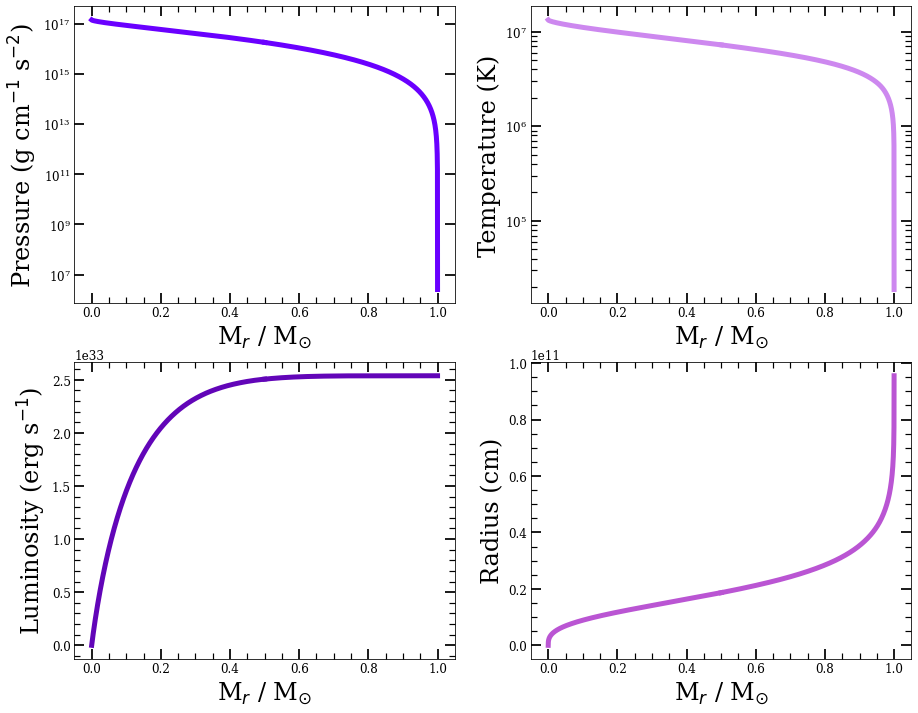

In [25]:
import time


def minimizer(scoring_function, method='root'):
    
     #* lambda_P,* lambda_T,  * lambda_L,  * lambda_R
    initial_guess = [0.58527923 * 2.477e17, 0.84399857 *  1.571e7 , 0.66248493 * 3.846e33, 1.37823259 * 6.957e10]#[1., 1., 1., 1.]
   

    optimization_result = root(scoring_function, x0= initial_guess, tol=1e-4)

    print(optimization_result)
    print()
    print(optimization_result.x)

    return optimization_result.x
    
    
    
    
def main():
    beep = True
    start = time.time()

    try:
        best2 = minimizer(fSCO_root, method='root')
        
        Pc, Tc, Lstar, Rstar = best2#define_inputs(best2)

        in_best, out_best = fshoot_fine(Pc, Tc, Lstar, Rstar)
        fig2, ax_P2, ax_T2, ax_L2, ax_R2 = plot_attempt(in_best, out_best)
        fig2.savefig('Plots\\Bestfit.pdf', dpi=400, bbox_inches='tight')
    except (ValueError, KeyError):
        frequency = 700  # Set Frequency To 2500 Hertz
        duration = 700  # Set Duration To 1000 ms == 1 second

        if beep == True:
        
            winsound.Beep(frequency, duration)
            winsound.Beep(frequency, duration)
        
    frequency = 400  # Set Frequency To 2500 Hertz
    duration = 700  # Set Duration To 1000 ms == 1 second

    if beep == True:
    
        winsound.Beep(frequency, duration)
    

    end = time.time()
    print('This process took ',int((end - start) // 60),' minutes and ',(end - start) % 60 ,' seconds! Wow!')
        
#[1.44885529e+17, 1.32500058e+07, 2.53830540e+33, 9.59076319e+10]
main()

<ipython-input-19-e1a716dbf83c>:71: RuntimeWarning: divide by zero encountered in log10
  ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]), full_true_gradients[0:],color='black',alpha=0.9, lw=9, label='$\\nabla_{true}$', zorder=-50)
<ipython-input-19-e1a716dbf83c>:72: RuntimeWarning: divide by zero encountered in log10
  ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]), full_delrad[0:], ls='--',lw=5,color='#6A00FF', label='$\\nabla_{rad}$')
<ipython-input-19-e1a716dbf83c>:73: RuntimeWarning: divide by zero encountered in log10
  ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]), full_delad[0:], ls='--',lw=5, color='#9400D3', label='$\\nabla_{ad}$')
<ipython-input-19-e1a716dbf83c>:75: RuntimeWarning: divide by zero encountered in log10
  ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]),np.log10(full_kappa) / np.nanmax(np.log10(full_kappa) ),color='#6205B8', lw=3, ls='-.', label='log Opacity')
<ipython-input-19-e1a716dbf83c>:76: RuntimeWarning: divide by zero encountered in log10
  ax.plot(-np.log10(1 - 

My Pc, Tc, L*, R*:  [1.44885529e+17 1.32500058e+07 2.53830540e+33 9.59076319e+10]
MESA Pc, Tc, L*, R*:  [1.43640882e+17 1.36361886e+07 2.68467653e+33 6.17840310e+10]
Percent Differences:  [ 0.86649893  2.83204372  5.45209547 55.23045417]

My L*, R*, Teff, log g:  [2.53830540e+33 9.59076319e+10 4.43610062e+03 4.15922289e+00]
MESA L*, R*, Teff, log g:  [2.68467653e+33 6.17840310e+10 5.60501624e+03 4.54117674e+00]
Percent Differences:  [ 5.45209547 55.23045417 20.85481239  8.41090047]



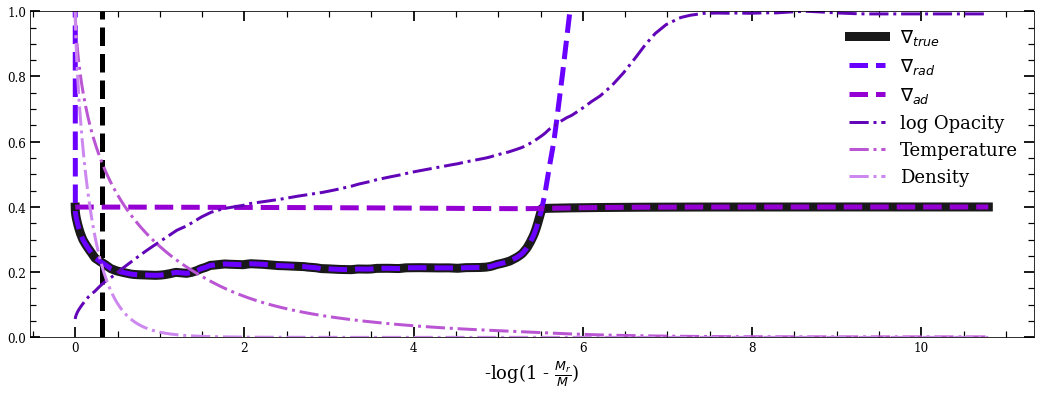

In [19]:
def create_machine_readable_table(best_initial_values):
    
    Pc, Tc, Lstar, Rstar = best_initial_values

    inner_result, outer_result = fshoot_fine(Pc, Tc, Lstar, Rstar)
    
    
    inner_result_m = inner_result.t
    inner_result_y = inner_result.y

    inner_result_l = inner_result.y[0]
    inner_result_P = inner_result.y[1]
    inner_result_r = inner_result.y[2]
    inner_result_T = inner_result.y[3]
    
    outer_result_m = outer_result.t
    outer_result_y = outer_result.y

    outer_result_l = outer_result.y[0]
    outer_result_P = outer_result.y[1]
    outer_result_r = outer_result.y[2]
    outer_result_T = outer_result.y[3]
    
    full_m = np.concatenate((inner_result_m, outer_result_m[::-1]))
    full_l = np.concatenate((inner_result_l, outer_result_l[::-1]))
    full_P = np.concatenate((inner_result_P, outer_result_P[::-1]))
    full_r = np.concatenate((inner_result_r, outer_result_r[::-1]))
    full_T = np.concatenate((inner_result_T, outer_result_T[::-1]))

    X = 0.7
    Z = 0.02 
    
    full_rho = density(full_P, full_T, X)


    full_delad = del_adiabatic(full_P, full_T)
    
    full_true_gradients = np.zeros_like(full_delad)
    full_delrad = np.zeros_like(full_delad)
    which_gradient = []
    
    full_R = R_opacity(full_rho, full_T)

    full_epsilon = energy_epsilon(full_rho, full_T, X, Z, verbose=False)
    
    full_kappa = opacity_function(full_R, full_T)
    
    
    for i in range(len(full_m)):
        
        Mr = full_m[i]
        P = full_P[i]
        kappa = full_kappa[i]
        T = full_T[i]
        Lr = full_l[i]
        full_delrad[i] = del_radiative(Mr, P, kappa, T, Lr)
        grad, which = choose_gradient(Mr, P, kappa, T, Lr, verbose=True)
        full_true_gradients[i] = grad
        which_gradient.append(which)
    
    d = {
          'Mr':full_m, 'Lr':full_l, 'P':full_P, 'r':full_r, 'T':full_T, 
          'rho':full_rho, 'kappa':full_kappa, 'epsilon':full_epsilon,
          'del_rad':full_delrad, 'del_ad':full_delad,
          'del_actual':full_true_gradients, 'gradient_type':which_gradient
         }
    
    full_data = pd.DataFrame(data=d)
##b2df8a #33a02c #F554A7 #ED4D6E #FFB54D #1f78b4
    fig, ax = plt.subplots(1,1, figsize=(18,6))
    ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]), full_true_gradients[0:],color='black',alpha=0.9, lw=9, label='$\\nabla_{true}$', zorder=-50)
    ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]), full_delrad[0:], ls='--',lw=5,color='#6A00FF', label='$\\nabla_{rad}$')
    ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]), full_delad[0:], ls='--',lw=5, color='#9400D3', label='$\\nabla_{ad}$')
    
    ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]),np.log10(full_kappa) / np.nanmax(np.log10(full_kappa) ),color='#6205B8', lw=3, ls='-.', label='log Opacity')
    ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]),full_T / np.nanmax(full_T),color='#BA55D3', lw=3, ls='-.', label='Temperature')
    #ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]),full_P / np.nanmax(full_P), lw=3, ls='-.', label='Pressure')
    ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]),full_rho / np.nanmax(full_rho), color='#CD88EF', lw=3, ls='-.', label='Density')
    #ax.plot(-np.log10(1 - full_m[0:]/full_m[-1]),full_epsilon / np.nanmax(full_epsilon), lw=3, ls='-.', label='Epsilon')
    ax.legend(fontsize=18, fancybox=False, frameon=False)
    ax.vlines(-np.log10(1 - full_m[len(full_m) // 2]/full_m[-1]), 0., 1., color='k',zorder=-100,lw=5, ls='--')
    ax.set_xlabel('-log(1 - $\\frac{M_r}{M}$)',fontsize=18)

    ax.set_ylim(0, 1)
    
    full_data.to_csv('machine_readable_table.csv')
    fig.savefig('Plots\\convection.pdf', dpi=400, bbox_inches='tight')
    
def Teff(Lstar, Rstar):
    T_init_outer = np.power(Lstar / (4. * np.pi * np.square(Rstar) * sb), 0.25)
    return T_init_outer
    
def logg(M, R):
    
    return np.log10(G * M / np.square(R))

    
    
def mesa_comparison(my_values):

    my_values = np.array([1.44885529e+17, 1.32500058e+07, 2.53830540e+33, 9.59076319e+10])
    mesa_output = np.array([1.891658,7.134693,-0.153853,-0.051733])
    L_mesa = np.power(10., mesa_output[2]) * Ls
    R_mesa = np.power(10., mesa_output[3]) * Rs
    T_mesa = np.power(10., mesa_output[1])
    D_mesa = np.power(10., mesa_output[0])
    X = 0.7
    radiation_pressure = a * np.power(T_mesa, 4.) / 3.

    mu = 4. / (3. + 5. * X)

    ideal_gas_pressure = D_mesa * (T_mesa * Rg) / mu 

    P_mesa = ideal_gas_pressure + radiation_pressure

    mesa_values = np.array([P_mesa, T_mesa, L_mesa, R_mesa])
    percent_difference = np.abs(my_values - mesa_values) * 100. / mesa_values
    print('My Pc, Tc, L*, R*: ',my_values)
    print('MESA Pc, Tc, L*, R*: ',mesa_values)
    print('Percent Differences: ',percent_difference)
    print()
    my_extras = np.array([my_values[2],my_values[3], Teff(my_values[2], my_values[3]), logg(Ms, my_values[3])])
    mesa_extras = np.array([mesa_values[2],mesa_values[3], Teff(mesa_values[2], mesa_values[3]), logg(Ms, mesa_values[3])])
    percent_difference_extras = np.abs(my_extras - mesa_extras) * 100. / mesa_extras
    print('My L*, R*, Teff, log g: ',my_extras)
    print('MESA L*, R*, Teff, log g: ',mesa_extras)
    print('Percent Differences: ',percent_difference_extras)
    
    print()
    
def main():
    best_values = [1.44885529e+17, 1.32500058e+07, 2.53830540e+33, 9.59076319e+10]
    create_machine_readable_table(best_values)
    mesa_comparison(best_values)
    
main()

In [262]:

#leftover code        
        
    #*(np.square(np.log10(opacities_nonan)+3.))
    #z_control = np.power(10., interp(np.log10(xR_nonan),np.log10(yT_nonan)))

    #ax1 = fig.add_subplot(gs[0,1])
    #ax2 = fig.add_subplot(gs[1, :])
    #ax2.set_yscale('log')
    #ax2.set_xscale('log')

    
    #ax1 = full_tickmarks(ax1)
    #ax2 = full_tickmarks(ax2)

    #ax1.hist(np.abs(opacities_nonan-z_control), bins=70, color='#33a02c', rasterized=True)



    #ax2.hlines(0.1, np.min(xR_nonan), np.max(xR_nonan), color='k', lw=4, ls='--')
    #ax2.scatter(xR_nonan,np.abs(opacities_nonan-z_control)/ opacities_nonan, c=yT_nonan, s=60)
    #ax2.set_xlabel('R $\\equiv$ $\\rho$ / (T$_6$)$^3$', fontsize=24)
    #ax2.set_ylabel(r'$(\kappa_{OPAL} - \kappa_{interpolated} )/ \kappa_{OPAL}$ (cm$^{2}$ g$^{-1}$)', fontsize=24)
    #ax_ins = inset_axes(ax1, 5., 3.75, loc=3, bbox_to_anchor=(.68, .65),
                  #bbox_transform=ax1.figure.transFigure)

    #ax_ins = full_tickmarks(ax_ins)
      
    #ax_ins.hist(np.abs(opacities_nonan-z_control)[np.abs(opacities_nonan-z_control) < 1], bins=70, color='#33a02c', rasterized=True)
    
    #ax_ins.set_xscale('log')
    #ax_ins.set_xlim(1e12,1e15)
    #ax_ins.set_ylabel('N', fontsize=20)
    #ax_ins.set_xlabel(r'Opacity Difference (cm$^{2}$ g$^{-1}$)', fontsize=20)
    #ax1.set_xlabel(r'$\kappa_{OPAL} - \kappa_{interpolated}$ (cm$^{2}$ g$^{-1}$)', fontsize=24)
    #ax1.set_ylabel('N', fontsize=24)
    #ax_ins.set_yscale('log')
    #ax_ins.set_ylim(0., 2 * x20_accepted[-1])
    #ax_ins.fill_between([lower_bound+boundary/2, upper_bound-boundary/2], 1e8, 1e11, color='blue', alpha=0.1)
    #ax_ins.vlines(flash_point_days, np.min(ys)* 0.8, np.max(ys)*1.2, ls='--', color='k', lw=2.)
    #mark_inset(ax1, ax_ins, loc1=2, loc2=4, ec="0.1")

    #ax.add_colorbar()
    
        
#def fSCO(inputs):
    

    
#    lambda_P, lambda_T, lambda_L, lambda_R = inputs
    
#    Pc, Tc, Lstar, Rstar = define_inputs([lambda_P, lambda_T, lambda_L, lambda_R])
    
    #print(Pc/2.477e17, Tc/1.571e7, Lstar/3.846e33, Rstar/6.957e10)
    #d_in, d_out = fshoot(2.477e17, 1.571e7, 3.846e33, 6.957e10)
    #print(d_in, d_out)
#    inner_result, outer_result = fshoot(Pc, Tc, Lstar, Rstar)
    #print(inner_result);
    #print(outer_result)
    #print('a')
    
#    inner_result_y = inner_result.y
    #print('b')
#    inner_result_l = inner_result.y[0]
#    inner_result_P = inner_result.y[1]
#    inner_result_r = inner_result.y[2]
#    inner_result_T = inner_result.y[3]

#    outer_result_y = outer_result.y
    #print('c')
#    outer_result_l = outer_result.y[0]
#    outer_result_P = outer_result.y[1]
#    outer_result_r = outer_result.y[2]
#    outer_result_T = outer_result.y[3]
    #print('d')
    #print(outer_result_l, outer_result_P, outer_result_r, outer_result_T)
#    l_diff = inner_result_l[-1] - outer_result_l[-1]
#    P_diff = inner_result_P[-1] - outer_result_P[-1]
#    r_diff = inner_result_r[-1] - outer_result_r[-1]
#    T_diff = inner_result_T[-1] - outer_result_T[-1]
    #print('e')
#I'm going to try to balance the scoring function, so that it isn't dominated by the luminosity.

#    return np.sqrt(np.square(l_diff/1.846e33) + np.square(P_diff/2.477e17) + np.square(r_diff/5.957e9) + np.square(T_diff/0.571e7))

 #[2.477e17, 1.571e7, 3.846e33, 6.957e10]
    #[3.477e17, 4.571e7, 2.846e33, 5.957e10]#
    
    #reasonable_bounds = Bounds(lb=[0.4, 0.9, 0.9, 0.9], ub=[1.2, 1.2, 1.3, 1.7])
    #if method == 'minimize':
    
    #    optimization_result = minimize(scoring_function, initial_guess, options={'maxiter':100},tol=1e-11, bounds=reasonable_bounds)
    #    print(optimization_result.x)
    #    print(optimization_result.success)
    #    print(optimization_result.nit)
    #    print(optimization_result)
    #else:
    
#def define_inputs(inputs):
   
#    lambda_P, lambda_T, lambda_L, lambda_R = inputs

#    return 2.477e17 * lambda_P, 1.571e7 * lambda_T, 3.846e33 * lambda_L, 6.957e10 * lambda_R
    